# Replication Keras Notebook

I am simply using this notebook to learn the techniques Giorgos F demonstrated in his notebook at https://www.kaggle.com/giorgosfoukarakis/moa-eda-fastica-dnn-label-smoothing; if I can get that far, then I can look for ways to improve it.

This will also be an exercise in writing clearer documentation of my steps.


## GF's notes on experimenting with model parameters and pre/post processing data

"I tested various techniques and parameters during this work, some of them improved my LB significally.

1. Using cp_type column : predictions after removing this feature were less accurate.
1. Using Standard /Minmax scaling but Normal Quantile Transform before ICA lead to better predictions
1. Label smoothing is definitely leading to improved scores due to the way of LB scoring system. Trying to use values larger than 0.001/0.999 for min/max lowered scores.
1. Adding weight normalization was tested too but without any success
1. Testing AdamW, LazyAdam optimizers, didn't improve results
1. Testing Leaky_relu ,elu no obvious improvement
1. Changing batch size from 128 up to 512 didn't change LB score (as expected)
1. Using larger models : more hidden layers and/or nodes per layer up to 8192/2048 showed small improvement (possibly due to some extra overfitting)
1. Tried batch normalization before the activation function, not suitable for our activations
1. Tested different values for FastICA independent components"


In [1]:
import numpy as np
import pandas as pd
import category_encoders as ce
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing as pp
from sklearn.decomposition import FastICA
from sklearn.model_selection import train_test_split, StratifiedKFold

In [2]:
import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
sns.set_style('whitegrid')

In [4]:
import tensorflow as tf
import keras.backend as K
from keras import utils
from keras.models import Model
from keras.layers import BatchNormalization, Dense, Input, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
def logloss(y_true,y_pred):
    # y_pred = tf.clip_by_value(y_pred,1e-20,1-1e-20)
    y_pred = tf.clip_by_value(y_pred,0.001,0.999)
    return -K.mean(y_true*K.log(y_pred) + (1-y_true)*K.log(1-y_pred))

# Loading datasets
I don't know why everyone doesn't load the data into a dataframe setting `sig_id` as the index... but no one does. Here's the rundown:
* pandas read csv data and set index values to `sig_id`
* set `cp_type` and `cp_dose` to categorical data. This isn't necessary. The `category_encoders` library doesn't actually pay attention to this. Still, I like the functionality and it's useful in other contexts.
* `category_encoders.OrdinalEncoder` seeks out string columns and converts the labels to integers... starting from 1. Since `cp-type` and `cp_dose` only have two distinct labels, these are mapped to 1 and 2.
* since nobody wants 1 and 2, I subtract 1 elementwise from each of these columns to get the desired 0 and 1 binary encoding.

Fun fact: I didn't use the `BinaryEncoder` because the documentation says, "Binary encoding for categorical variables, similar to onehot, but stores categories as binary bitstrings." https://contrib.scikit-learn.org/category_encoders/binary.html No idea how that would play with Keras. I want integers: "Encodes categorical features as ordinal, in one ordered feature. Ordinal encoding uses a single column of integers to represent the classes." https://contrib.scikit-learn.org/category_encoders/ordinal.html

Our man GF does what I suspect is the normal thing and uses a `get_dummies` method (`pandas`' method; `sklearn` has one, too, which I use for clusters) which, if you `drop_first`, does the same thing, but by God I'm encoding a single column as integers, not transforming a single column into a number of columns, the second number just happening to also be one...

* I use `MinMaxScaler` to map the times to -0.5, 0, +0.5 instead of literally using `.map` to make them 1, 2, 3 because, you know, neural nets and features centered at 0.

In [6]:
tf_df = pd.read_csv('../input/lish-moa/train_features.csv',index_col='sig_id')
tts_df = pd.read_csv('../input/lish-moa/train_targets_scored.csv',index_col='sig_id')
tf_df['cp_type']=tf_df['cp_type'].astype('category')
tf_df['cp_dose']=tf_df['cp_dose'].astype('category')
print(tf_df['cp_type'].unique(),tf_df['cp_dose'].unique())
oenc = ce.ordinal.OrdinalEncoder()
tf_df = oenc.fit_transform(tf_df)
tf_df['cp_type']=tf_df['cp_type']-1
tf_df['cp_dose']=tf_df['cp_dose']-1
tf_df.info()

['trt_cp', 'ctl_vehicle']
Categories (2, object): ['trt_cp', 'ctl_vehicle'] ['D1', 'D2']
Categories (2, object): ['D1', 'D2']
<class 'pandas.core.frame.DataFrame'>
Index: 23814 entries, id_000644bb2 to id_ffffdd77b
Columns: 875 entries, cp_type to c-99
dtypes: float64(872), int64(3)
memory usage: 159.2+ MB


In [7]:
tts_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23814 entries, id_000644bb2 to id_ffffdd77b
Columns: 206 entries, 5-alpha_reductase_inhibitor to wnt_inhibitor
dtypes: int64(206)
memory usage: 37.6+ MB


In [8]:
testf_df = pd.read_csv('../input/lish-moa/test_features.csv',index_col='sig_id')
testf_df['cp_type']=testf_df['cp_type'].astype('category')
testf_df['cp_dose']=testf_df['cp_dose'].astype('category')
testf_df = oenc.transform(testf_df)
testf_df['cp_type']=testf_df['cp_type']-1
testf_df['cp_dose']=testf_df['cp_dose']-1
testf_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3982 entries, id_0004d9e33 to id_ffd5800b6
Columns: 875 entries, cp_type to c-99
dtypes: float64(872), int64(3)
memory usage: 26.6+ MB


In [9]:
# I imported sklearn.preprocessing with the unorthodox abbreviation pp
scaler = pp.MinMaxScaler(feature_range=(-0.5,0.5))
tf_df['cp_time']=scaler.fit_transform((np.array(tf_df['cp_time'])).reshape(-1,1))
testf_df['cp_time']=scaler.transform((np.array(testf_df['cp_time'])).reshape(-1,1))

So the first inexplicable thing our man GF does, immediately after reading in the data, is to... hey, I read the code a fourth time and saw it. He culls the columns that aren't all zeros from the `train_targets_nonscored` file and rams them onto the scored targets file. Interesting. I won't do that for now.

# EDA

I did a bunch of EDA in an offline notebook (offline? heck, it's on Dotun's Moa repo on github) and saw pretty much what GF saw. His seaborn KDE plots do make things look clearer to assess all the gene and cell features at once.

One thing I don't remember seeing in my EDA was the high level of correlation between cell features. I DID notice, in the separated-pca notebooks where I broke gene and cell features apart to do PCA, was that 85% of the explained variance in the cell features was concentrated in the first PCA component, which I affectionately called the SCREECH KILL KILL component. This component has a negative coefficient for every feature and presumably represents broad spectrum toxicity. The concentration of variation in this single component is completely consistent with there being high intercorrelation between the cell features.

GF gives some context on what agonists, antagonists, activators, and inhibitors are.

He presents some plots with the same info that Matt showed about how many rows / `sig_id`s / experiments have 0, 1, or more hits on the target MoAs. There are a *lot* of empty rows in the non-scored targets matrix.

# Feature Engineering

GF performs three stages of feature engineering:
1. `VarianceThreshold`: Stack train and test features together, then select features with a threshold of 0.95. He interprets his procedure as "So we will use data as is and try VarianceThreshold to detect and remove low variance features (we have already scaled our data). Target variability was set to 90% with trial and error." So far as I can tell, I'm certain he has NOT scaled the data yet, and he's selecting features with variance > 0.95 on the supplied -10 to +10 scale. I verified this by running his own notebook.
1. `QuantileTransformer`: A brutal method to rescale a dataset to pull in outliers and produce an evenly distributed dataset, with the option to further transform this into a normally distributed dataset. He uses 100 quantiles and the normal option, just like the other source I consulted. The sklearn docs show an illustration of the results: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#quantiletransformer-gaussian-output
1. `FastICA`: A more sophisticated dimensionality reduction technique than PCA, which to read GF's references itself depends on a dedicated neural network routine. His notebook implies that he tried ICA with 80 gene components and 20 cell components, then scrapped that approach and went with 300 components across all floating point features. Having compared models with PCA analysis on gene and cell features together (actually, the whole dataset, `cp` features too) to models with PCA done on the split features, I think that leaving them together is the way to do it, even aside from the question of how many dimensions to use.

In [10]:
totalf_df = pd.concat([tf_df,testf_df],axis=0)
weeder = VarianceThreshold(0.95)
# high variance features retained
highvf_arr = weeder.fit_transform(totalf_df.loc[:,'g-0':'c-99'])
highvf_arr.shape

(27796, 717)

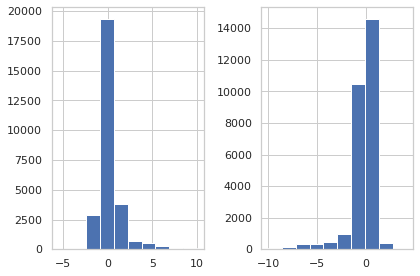

In [11]:
# let's plot a few features...
fig, ax = plt.subplots(1,2)
ax[0].hist(x=highvf_arr[:,0])
ax[1].hist(x=highvf_arr[:,-1])
plt.tight_layout()
plt.show()

In [12]:
# I imported sklearn.preprocessing with the unorthodox abbreviation pp
leveller = pp.QuantileTransformer(n_quantiles=100,output_distribution='normal')
highvf_arr = leveller.fit_transform(highvf_arr)
highvf_arr.shape

(27796, 717)

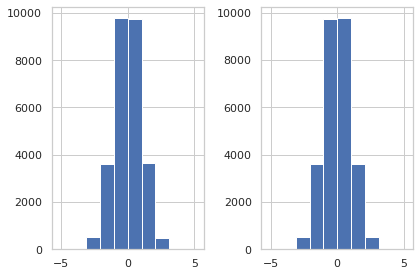

In [13]:
# let's plot a few features...
fig, ax = plt.subplots(1,2)
# for some bloody reason this code just hung
#sns.countplot(x=highvf_arr[:,0],ax=ax[0])
#sns.countplot(x=highvf_arr[:,-1],ax=ax[1])
ax[0].hist(x=highvf_arr[:,0])
ax[1].hist(x=highvf_arr[:,-1])
plt.tight_layout()
plt.show()

Note that the data is still not standardized (mean 0, variance 1, or anything all that close). `QuantileTransformer(normal)` seems to shoehorn the data into a normal distribution with the same mean and variance as before.

In [14]:
ica = FastICA(n_components=300, max_iter=500)
icaf_arr = ica.fit_transform(highvf_arr)

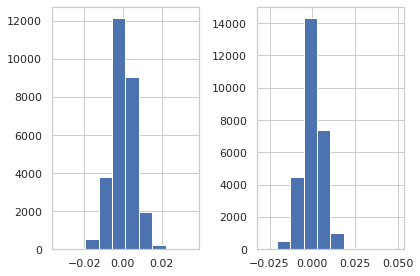

In [15]:
# let's plot a few features...
fig, ax = plt.subplots(1,2)
ax[0].hist(x=icaf_arr[:,0])
ax[1].hist(x=icaf_arr[:,-1])
plt.tight_layout()
plt.show()

So *that's* where the features get standardized-ish. Lemme check that.

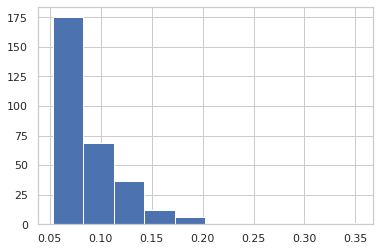

In [16]:
icaf_df = pd.DataFrame(icaf_arr,index=totalf_df.index,
                      columns=['ica'+str(i) for i in range(icaf_arr.shape[1])])
ica_ranges = icaf_df.max()-icaf_df.min()
plt.hist(x=ica_ranges)
plt.show()

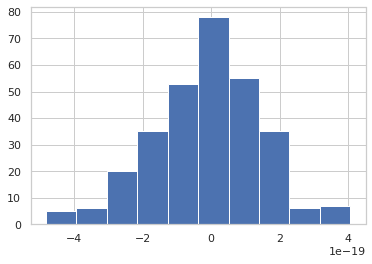

In [17]:
ica_means = icaf_df.mean()
plt.hist(ica_means)
plt.show()

Those are beyond standardized. I would think they're *too* small in variance; in any case, the means are decidedly 0.

At this point he rams these ICA features onto the right side of the original feature matrix. Wow, this is a common procedure. So much for getting *rid* of repetitive data; we're just complementing it with presumably more concentrated forms of the same features.

In [18]:
augmentf_df = pd.concat([totalf_df,icaf_df],axis=1)
augtf_df = augmentf_df.iloc[:tf_df.shape[0],:]
augtestf_df = augmentf_df.iloc[-testf_df.shape[0]:]
assert len(augmentf_df) == len(augtf_df)+len(augtestf_df)

So as far as I can tell, I'm still going to need to `StandardScale` the base gene and cell features. And yet if he doesn't, then I'd better not... for now. For now I just want to get in the vicinity of that tasty 0.01878 using thoroughly digested and understood and rephrased code. So far the only actual changes I know I have made are
1. skipping adding the nonscored targets. Unless something in the network shows where he feeds that data in to inform predictions on the scored targets, that should make no difference. Tiny change if needed.
1. mapping `cp_time` to -0.5 to +0.5 instead of 1 to 3. That should be a miniscule improvement and is in any case trivial to change.

Code stockpile:

`transformer = StandardScaler()
tf_df.loc[:,'g-0':'c-99']=transformer.fit_transform(tf_df.loc[:,'g-0':'c-99'])`

`testf_df.loc[:,'g-0':'c-99']=transformer.transform(testf_df.loc[:,'g-0':'c-99'])
testf_arr = np.array(testf_df)`

Following both my own custom and GF's lead, let's explicitly create numpy arrays to hold the train, target, and test data.

In [19]:
tf_arr = augtf_df.values
testf_arr = augtestf_df.values
tts_arr = tts_df.values

In [20]:
n_features = tf_arr.shape[1]
n_labels = tts_arr.shape[1]
n_train = tf_arr.shape[0]
n_test = testf_arr.shape[0]

# Model building
GF sticks it into a function like the ones for `kerastuner`. Moreover, he implements a *k*-fold cross-validation that I will do my best to untangle and understand.

In [21]:
strategy = tf.distribute.get_strategy()
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


He uses the *Sequential* mode in Keras [shudder]. Let's not do that.

In [22]:
with strategy.scope():
    def build_model(X, y):
        '''Takes the train (or test) feature and label arrays
        as parameters to set the dimensions of the input
        and output layers.'''
        K.clear_session()
        inputs = Input(shape=(X.shape[1],))
        x = BatchNormalization()(inputs)
        x = Dropout(0.5)(x)
        x = Dense(2048,activation='relu',
                 input_shape=(X.shape[1],))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(2048,activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        outputs = Dense(y.shape[1],activation='sigmoid')(x)
        model = Model(inputs,outputs)
        return model

He defines the following callbacks.

In [23]:
reduce_lr = ReduceLROnPlateau(monitor='val_logloss', factor=0.3, 
                              patience=5, mode='min', min_lr=1E-5)
early_stopping = EarlyStopping(monitor='val_logloss', min_delta=1E-5, 
                               patience=15, mode='min',
                               restore_best_weights=True)

He chooses different random seeds for each iteration of cross-validation. Note that with six seeds and five folds, he trains the model 30 times and gets an ensemble prediction. Velly inspirational. That should hack back a lot of overtraining. Since I'm going to fire and forget this notebook, let's do 10 seeds.

In [24]:
n_seeds = 10
np.random.seed(84)
seeds = np.random.randint(0,100,size=n_seeds)
n_folds = 5

Here we initialize a prediction array for submission and an out-of-fold tensor to hold an average out-of-fold score. I note with dismay that in the end this is still about half his... *half*...?  his actual submission score for the notebook. But as I note later, *he's scoring on all those extra targets*.

In [25]:
predts_arr = np.zeros((n_test,n_labels))
oof = 0.0
hists = []

Here in the BCE options and coded into the `logloss` function at the top, note the 0.001 label smoothing parameter, not to be confused with the 0.001 (default) learning rate in Adam. I, personally, am going to dial the batch size down from 128 to 32, which I think is a default anyway. He claimed bigger batch sizes than 128 didn't make much difference, but I've observed fits to go up for smaller batch sizes when I was working on the NMR project.

In [26]:
# not sure if import from keras vs. tf.keras is significant
opt = tf.keras.optimizers.Adam(lr=0.001, decay=0.001/200)
bce = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.001)
n_batch = 32
n_epochs = 40

Here's where the magic happens, and I'm very happy I took the time to walk through and paraphrase his code.

That said, the nomenclature here worries me; I think it's non-standard and somewhat confusing. We are using the data that hitherto has been "training" data and splitting it via cross-validation to train and test the model. The "y_val" is not validation data in the ordinary sense; it's the prediction from each iteration of the model on that slice of test data, which is "manually" scored by calling our custom-written loss function on the test and prediction arrays. Meanwhile we are saving / aggregating predictions on the, back up a step, "test" data that we have to predict labels / targets for in order to submit a score to Kaggle. So "test" is ambiguous and "validation" is not being used in what I learned was the ordinary sense of a three-way split of train, test, and validate data.

*That* said, here's what's going on.

* Loop over all *seeds*.
* Use the seed to initialize the data splitter. The cross-validation slices the data into a specified number of folds.
* The inner loop loops over all the folds by turns. Each fold takes a turn being the holdout, test fold, and the rest of the data is placed in train for that iteration of the loop.
* The splitter actually just supplies the appropriate groups of indices for the splits, which we then use to index the arrays of input and output data for training and testing.
* The model is built and fit and its loss history is saved to a list of *dictionaries* of arrays.
    * Something was broken with the callbacks and the validation data coming back in the keras history. Turns out you cannot put the validation datasets in a list, it *must* be a tuple... who knew?
    * I am getting different losses, but of course I should get a different loss because he's scoring all those additional targets.
* We save each model just in case...?
* Compare predictions on the test features to the test labels and calculate a new out of fold score. Add this to the running average.
* Calculate a new addition to our running prediction on the "test" data for the competition.
* I added a per-fold report on the out of fold score to the overall report.

Something is very, very wrong with the running loss calculation. God, I hate tensor libraries. Why is the "per trial" loss continuing to accumulate?

In [30]:
for seed in seeds:
    print('\nSeed value for this iteration:',seed,'\n')
    fold = 0
    mltsplit = MultilabelStratifiedKFold(n_splits=n_folds,
                                        shuffle=True,
                                        random_state=seed)
    for train, test in mltsplit.split(tf_arr, tts_arr):
        X_train = tf_arr[train]
        X_test = tf_arr[test]
        y_train = tts_arr[train]
        y_test = tts_arr[test]
        model = build_model(X_train, y_train)
        model.compile(optimizer=opt, loss=bce,metrics=[logloss])
        history = model.fit(X_train, y_train, batch_size=n_batch,
                           epochs=n_epochs, verbose=0,
                           validation_data=(X_test,y_test),
                           callbacks=[reduce_lr,early_stopping])
        hists.append(history)
        model.save('vqiks_model_seed'+str(seed)+'_fold'+str(fold))
        y_val = model.predict(X_test)
        # will average the out of fold score
        # across all seeds, all folds
        this_oof = (logloss(tf.constant(y_test,dtype=tf.float32),
                      tf.constant(y_val,dtype=tf.float32))).numpy()
        oof += this_oof / (n_folds * n_seeds)
        # will average the predictions for submission
        # across all seeds, all folds
        predts_arr += model.predict(testf_arr)
        print('For seed', seed, 'fold', fold,
              'out of fold log loss is', this_oof)
        fold += 1
print('Average out of fold log loss is', oof)


Seed value for this iteration: 42 



/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


For seed 42 fold 0 out of fold log loss is 0.018814221
For seed 42 fold 1 out of fold log loss is 0.01931777
For seed 42 fold 2 out of fold log loss is 0.020017726
For seed 42 fold 3 out of fold log loss is 0.02100196
For seed 42 fold 4 out of fold log loss is 0.022735117

Seed value for this iteration: 89 



/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=89 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


For seed 89 fold 0 out of fold log loss is 0.02560702
For seed 89 fold 1 out of fold log loss is 0.029740566
For seed 89 fold 2 out of fold log loss is 0.03571226
For seed 89 fold 3 out of fold log loss is 0.04216683


KeyboardInterrupt: 

Here we compile the scores for plotting. We should loop over seeds as well as folds, I think... will investigate that more later.

In [ ]:
len(hists[0].history['loss'])

There is a big fat problem here, because the EarlyStopping kicks in sometimes and then the history winds up short and numpy spits out that dumbass cryptic "can't be broadcast together" error.

In [ ]:
hist_train = np.zeros(n_epochs)
hist_val = np.zeros(n_epochs)
for i in range(n_folds):
    delta = n_epochs - len(hists[i].history['loss'])
    this_train = np.array(hists[i].history['loss'])
    this_train = np.pad(this_train, (0,delta), (0,0))
    hist_train += this_train / n_folds
    this_val = np.array(hists[i].history['val_loss'])
    this_val = np.pad(this_val, (0,delta), (0,0))
    hist_val += this_val / n_folds

In [ ]:
hists[0].history['val_loss']

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist_train)
plt.plot(hist_val)
#plt.yscale('log')
#plt.yticks(ticks=[1,0.1,0.01,0.001,0.0001])
plt.xlabel('Epochs')
plt.ylabel('Averaged Loss')
plt.legend(['Training','Validation'])
plt.show()

His creation of the prediction file is particularly confusing and roundabout. I think my existing solution works and is far more simple and straightforward.

In [ ]:
sub_df = pd.DataFrame(predts_arr,index=testf_df.index,
                      columns=tts_df.columns)
sub_df.head()

In [ ]:
sub_df.to_csv('/kaggle/working/submission.csv')